In [1]:
import sys
sys.path.append('/app')
from src.climate_learn import LitModule
from src.climate_learn import download_weatherbench
from src.climate_learn import convert_nc2npz
from src.climate_learn import IterDataModule
from src.climate_learn.utils import visualize_at_index, visualize_mean_bias
from src.climate_learn import load_downscaling_module
from src.climate_learn.utils.gis import prepare_ynet_climatology, prepare_deepsd_elevation
from src.climate_learn.models.module import DiffusionLitModule, LitModule, DeepSDLitModule, YnetLitModule
import pytorch_lightning as pl
from pytorch_lightning.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    RichModelSummary,
    RichProgressBar,
)
from pytorch_lightning.loggers.tensorboard import TensorBoardLogger
import torch
from cmip6_cmip6_dl import *
from hydra import compose, initialize
from omegaconf import OmegaConf
from torchvision import transforms

import math
import numpy as np
from matplotlib import pyplot as plt


/app/cmip6_cmip6_dl.py:21: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path="/app/configs/train", config_name="cmip6-cmip6")


In [4]:
import torchvision
from torch import nn
vgg_features = torchvision.models.vgg16(pretrained=True).features
modules = [m for m in vgg_features]

vgg = nn.Sequential(*modules[:4])

vgg.requires_grad = False

/opt/conda/envs/bias_correction/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/envs/bias_correction/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
modules

[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(512, 512, kernel_size=(3, 3), stride=(1

In [8]:
with initialize(version_base=None, config_path="../configs/train"):
    cfg = compose(config_name="cmip6-cmip6")

In [9]:
experiment_name = construct_experiment_name(cfg)
default_root_dir  = os.path.join(cfg.base_dir, experiment_name)

# Set the seed for reproducibility
pl.seed_everything(cfg.training.seed)

dm = setup_data_module(cfg)
elevation_list = prepare_deepsd_elevation(dm, path_to_elevation="/app/data/elevation.nc")
normalized_clim = prepare_ynet_climatology(dm, path_to_elevation="/app/data/elevation.nc", out_vars=cfg.data.out_variables)
module = setup_model(dm, cfg)
trainer = setup_trainer(cfg, default_root_dir )

Seed set to 777


Loading architecture: ynet
Using optimizer associated with architecture
Using learning rate scheduler associated with architecture
Loading training loss: perceptual


/opt/conda/envs/bias_correction/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/envs/bias_correction/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


No train transform
Loading validation loss: rmse
Loading validation loss: pearson
Loading validation loss: mean_bias
Loading validation loss: mse
Loading validation transform: denormalize
Loading validation transform: denormalize
Loading validation transform: denormalize
No validation transform
Loading test loss: rmse
Loading test loss: pearson
Loading test loss: mean_bias
Loading test transform: denormalize
Loading test transform: denormalize
Loading test transform: denormalize


Using 16bit Automatic Mixed Precision (AMP)
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [10]:

def plot_psd(imgs, label_prefixes = [''], linestyles=[None]):
    # curr_dir = os.getcwd()
    # img = cv2.imread(curr_dir+'/temp.png',0)
    assert (len(imgs) == len(label_prefixes)) and (len(imgs) <= len(linestyles)), "number of images labels and linestyles must match"
    # Fourier Transform along the first axis
    fig, (ax1, ax2) = plt.subplots(1, 2)
    for i in range(len(imgs)):
        img = imgs[i]
        label_prefix = label_prefixes[i]
        linestyle = linestyles[i]
        # Round up the size along this axis to an even number
        n = int( math.ceil(img.shape[0] / 2.) * 2 )

        # We use rfft since we are processing real values
        a = np.fft.rfft(img,n, axis=0)

        # Sum power along the second axis
        a = a.real*a.real + a.imag*a.imag
        a = a.sum(axis=1)/a.shape[1]

        # Generate a list of frequencies
        f = np.fft.rfftfreq(n)

        # Graph it
        ax1.plot(f[1:],a[1:], label = label_prefix + " " + 'PSD y vs f_x', linestyle = linestyle)
        ax1.set_ylabel('amplitude')
        ax1.set_ylabel('frequency')
        ax1.set_yscale('log')
        ax1.legend()
        # plt.ylabel( 'amplitude' )
        # plt.xlabel( 'frequency' )
        # plt.yscale( 'log' )
        # Fourier Transform along the second axis

        # Same steps as above
        n = int( math.ceil(img.shape[1] / 2.) * 2 )

        a = np.fft.rfft(img,n,axis=1)

        a = a.real*a.real + a.imag*a.imag
        a = a.sum(axis=0)/a.shape[0]

        f = np.fft.rfftfreq(n)

        ax2.plot(f[1:],a[1:],  label = label_prefix + " " + 'PSD x vs f_y', linestyle = linestyle)

        ax2.set_ylabel('amplitude')
        ax2.set_ylabel('frequency')
        ax2.set_yscale('log')

        ax2.legend()

    # plt.savefig( 'test_rfft.png' )
    # plt.show()

def setup_pretrained_module(module_class, module, checkpoint, **kwargs):
    model = module_class.load_from_checkpoint(
            # '/app/data/experiments/downscaling-ERA-ERA/deepsd_multi_none_0/logs/version_0/checkpoints/epoch_024.ckpt',
            checkpoint,
            net=module.net,
            optimizer=module.optimizer,
            lr_scheduler=module.lr_scheduler,
            train_loss=module.train_loss,
            val_loss=module.val_loss,
            test_loss=module.test_loss,
            train_target_transform=module.train_target_transform,
            val_target_transforms=module.val_target_transforms,
            test_target_transforms=module.test_target_transforms,
            **kwargs
        )
    return model

def plot_results_ckpts(module_class, module, checkpoints_dict, variable="2m_temperature", **kwargs):
    in_graphic_dict = {k: None for k in checkpoints_dict.keys()}
    for name, ckpt in checkpoints_dict.items():
        model = setup_pretrained_module(module_class, module, ckpt, **kwargs)
        denorm = model.test_target_transforms[0]
        # denorm_in = model.test_target_transforms[0]
        means = np.load("/app/data/processed/cmip6-cmip6/LR/normalize_mean.npz")
        stds = np.load("/app/data/processed/cmip6-cmip6/LR/normalize_std.npz")
        means = torch.tensor(np.array([means[k] for k in cfg.data.in_variables]).squeeze())
        stds = torch.tensor(np.array([stds[k] for k in cfg.data.in_variables]).squeeze())
        denorm_in = transforms.Normalize(-means/stds, 1/stds)
        
        print(name)
        in_graphic = visualize_at_index(
            model.to(device="cuda:1"),
            dm,
            in_transform=denorm_in,#transforms.Normalize(torch.zeros(12), torch.ones(12)),
            out_transform=denorm,
            # variable="10m_u_component_of_wind",
            # variable="2m_temperature",
            variable=variable,
            src="cmip6",
            index=0,
        )
        in_graphic_dict[name] = in_graphic[0]
    _, gt, inp = in_graphic
    plot_psd(list(in_graphic_dict.values()) + [gt], label_prefixes=list(in_graphic_dict.keys()) + ['gt'], linestyles=['solid', 'dashed', 'dashdot', 'dotted', '-', '--', '-.', ':', 'None', ' ', ''])
    return in_graphic_dict, gt, inp

In [11]:
# means = np.load("/app/data/processed/cmip6-cmip6/LR/normalize_mean.npz")
# stds = np.load("/app/data/processed/cmip6-cmip6/LR/normalize_std.npz")
# means = torch.tensor(np.stack(list(means.values())).squeeze())
# stds = torch.tensor(np.stack(list(stds.values())).squeeze())
# len(stds)

Ynet30


0it [00:01, ?it/s]


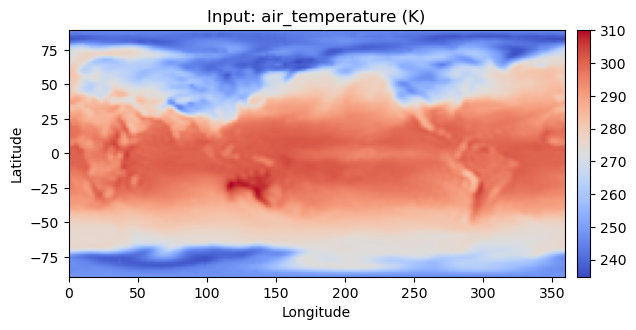

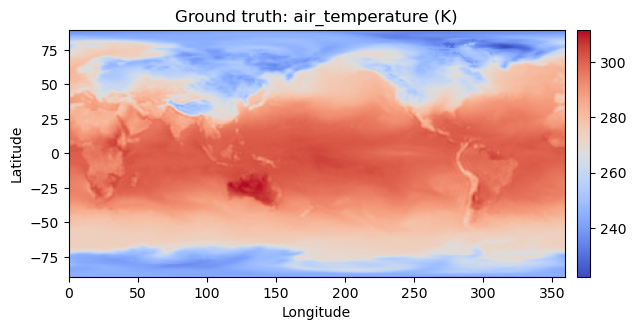

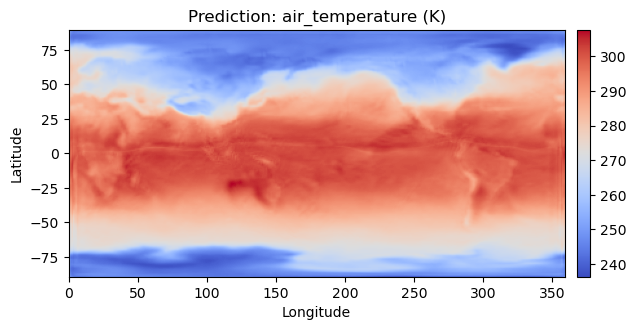

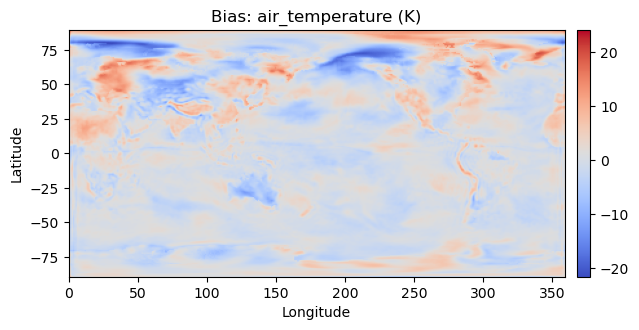

Ynet30-0.01-PL-relu_2


0it [00:00, ?it/s]


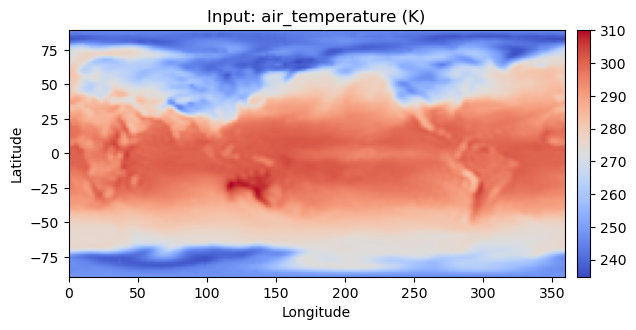

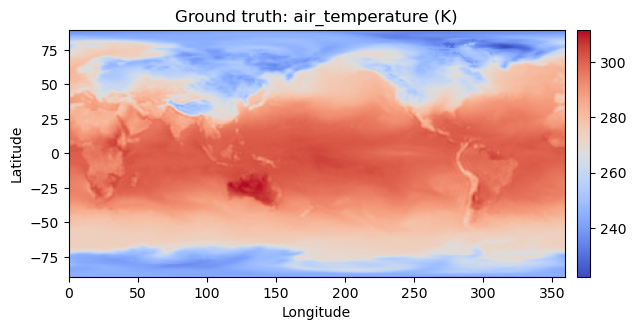

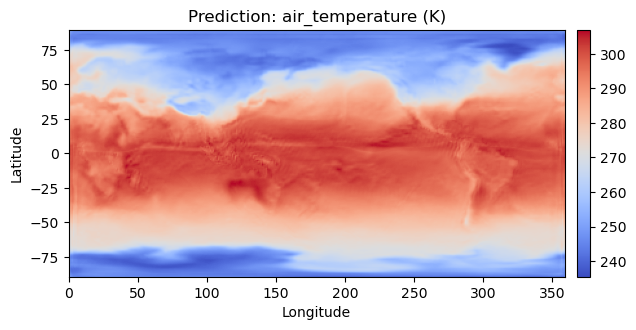

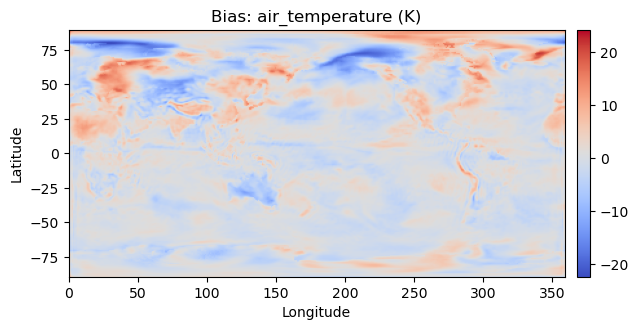

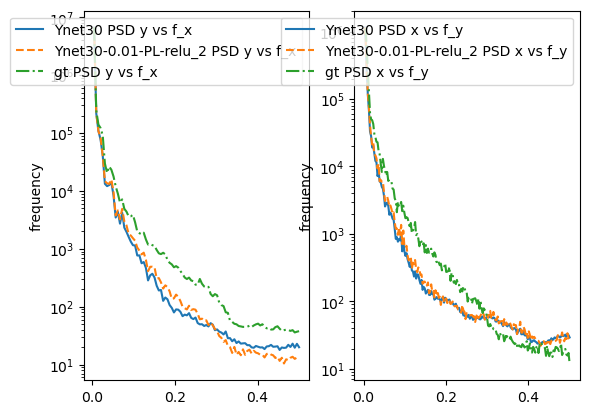

In [12]:
checkpoints_dict = {
    "Ynet30": "/app/data/experiments/downscaling-CMIP-CMIP/ynet_multi_none_777/logs/version_1/checkpoints/epoch_046.ckpt",
    "Ynet30-0.01-PL-relu_2": "/app/data/experiments/downscaling-CMIP-CMIP/ynet_multi_none_777/logs/version_0/checkpoints/epoch_047.ckpt",
}
pred, gt, inp = plot_results_ckpts(YnetLitModule, module, checkpoints_dict, variable="air_temperature", x_aux=normalized_clim)

In [13]:
checkpoints_dict = {
    "DeepSD": "/app/data/experiments/downscaling-CMIP-ERA-D/deepsd_multi_none_777/logs/version_42/checkpoints/epoch_040.ckpt",
    "DeepSD-0.01-PL-gram_relu_4": "/app/data/experiments/downscaling-CMIP-CMIP/deepsd_multi_none_777/logs/version_1/checkpoints/epoch_044.ckpt",
    "DeepSD-0.01-PL-gram_relu_2": "/app/data/experiments/downscaling-CMIP-CMIP/deepsd_multi_none_777/logs/version_2/checkpoints/epoch_042.ckpt",
    "DeepSD-0.1-PL-gram_relu_2": "/app/data/experiments/downscaling-CMIP-CMIP/deepsd_multi_none_777/logs/version_3/checkpoints/epoch_021.ckpt",
    "DeepSD-0.1-PL-relu_2": "/app/data/experiments/downscaling-CMIP-CMIP/deepsd_multi_none_777/logs/version_4/checkpoints/epoch_042.ckpt",
    "DeepSD-0.01-PL-relu_2": "/app/data/experiments/downscaling-CMIP-CMIP/deepsd_multi_none_777/logs/version_5/checkpoints/epoch_047.ckpt",
}
pred, gt, inp = plot_results_ckpts(DeepSDLitModule, module, checkpoints_dict, variable="u_component_of_wind", elevation=elevation_list)

RuntimeError: Error(s) in loading state_dict for DeepSDLitModule:
	Missing key(s) in state_dict: "net.conv_layers.0.0.weight", "net.conv_layers.0.0.bias", "net.conv_layers.1.0.weight", "net.conv_layers.1.0.bias", "net.conv_layers.2.0.weight", "net.conv_layers.2.0.bias", "net.conv_layers.3.0.weight", "net.conv_layers.3.0.bias", "net.conv_layers.4.0.weight", "net.conv_layers.4.0.bias", "net.conv_layers.5.0.weight", "net.conv_layers.5.0.bias", "net.conv_layers.6.0.weight", "net.conv_layers.6.0.bias", "net.conv_layers.7.0.weight", "net.conv_layers.7.0.bias", "net.conv_layers.8.0.weight", "net.conv_layers.8.0.bias", "net.conv_layers.9.0.weight", "net.conv_layers.9.0.bias", "net.conv_layers.10.0.weight", "net.conv_layers.10.0.bias", "net.conv_layers.11.0.weight", "net.conv_layers.11.0.bias", "net.conv_layers.12.0.weight", "net.conv_layers.12.0.bias", "net.conv_layers.13.0.weight", "net.conv_layers.13.0.bias", "net.conv_layers.14.0.weight", "net.conv_layers.14.0.bias", "net.deconv_layers.0.0.weight", "net.deconv_layers.0.0.bias", "net.deconv_layers.0.2.weight", "net.deconv_layers.0.2.bias", "net.deconv_layers.1.0.weight", "net.deconv_layers.1.0.bias", "net.deconv_layers.1.2.weight", "net.deconv_layers.1.2.bias", "net.deconv_layers.2.0.weight", "net.deconv_layers.2.0.bias", "net.deconv_layers.2.2.weight", "net.deconv_layers.2.2.bias", "net.deconv_layers.3.0.weight", "net.deconv_layers.3.0.bias", "net.deconv_layers.3.2.weight", "net.deconv_layers.3.2.bias", "net.deconv_layers.4.0.weight", "net.deconv_layers.4.0.bias", "net.deconv_layers.4.2.weight", "net.deconv_layers.4.2.bias", "net.deconv_layers.5.0.weight", "net.deconv_layers.5.0.bias", "net.deconv_layers.5.2.weight", "net.deconv_layers.5.2.bias", "net.deconv_layers.6.0.weight", "net.deconv_layers.6.0.bias", "net.deconv_layers.6.2.weight", "net.deconv_layers.6.2.bias", "net.deconv_layers.7.0.weight", "net.deconv_layers.7.0.bias", "net.deconv_layers.7.2.weight", "net.deconv_layers.7.2.bias", "net.deconv_layers.8.0.weight", "net.deconv_layers.8.0.bias", "net.deconv_layers.8.2.weight", "net.deconv_layers.8.2.bias", "net.deconv_layers.9.0.weight", "net.deconv_layers.9.0.bias", "net.deconv_layers.9.2.weight", "net.deconv_layers.9.2.bias", "net.deconv_layers.10.0.weight", "net.deconv_layers.10.0.bias", "net.deconv_layers.10.2.weight", "net.deconv_layers.10.2.bias", "net.deconv_layers.11.0.weight", "net.deconv_layers.11.0.bias", "net.deconv_layers.11.2.weight", "net.deconv_layers.11.2.bias", "net.deconv_layers.12.0.weight", "net.deconv_layers.12.0.bias", "net.deconv_layers.12.2.weight", "net.deconv_layers.12.2.bias", "net.deconv_layers.13.0.weight", "net.deconv_layers.13.0.bias", "net.deconv_layers.13.2.weight", "net.deconv_layers.13.2.bias", "net.deconv_layers.14.0.weight", "net.deconv_layers.14.0.bias", "net.deconv_layers.14.2.weight", "net.deconv_layers.14.2.bias", "net.subpixel_conv_layer.0.weight", "net.subpixel_conv_layer.0.bias", "net.subpixel_conv_layer.3.weight", "net.subpixel_conv_layer.3.bias", "net.fusion_layer.0.weight", "net.fusion_layer.0.bias", "net.fusion_layer.2.weight", "net.fusion_layer.2.bias". 
	Unexpected key(s) in state_dict: "net.srcnn_layers.0.conv1.weight", "net.srcnn_layers.0.conv1.bias", "net.srcnn_layers.0.conv2.weight", "net.srcnn_layers.0.conv2.bias", "net.srcnn_layers.0.conv3.weight", "net.srcnn_layers.0.conv3.bias". 

In [75]:
import torchvision
from torch import nn
torch.manual_seed(777)
vgg_features = torchvision.models.vgg16(pretrained=False).features
modules = [m for m in vgg_features]

# if conv_index == '22':
#     self.vgg = nn.Sequential(*modules[:8])
# elif conv_index == '54':
#     self.vgg = nn.Sequential(*modules[:35])
# vgg = nn.Sequential(*modules[:8])#.to(device)
# vgg_mean = (0.485, 0.456, 0.406)
# vgg_std = (0.229, 0.224, 0.225)
#self.sub_mean = common.MeanShift(rgb_range, vgg_mean, vgg_std)
# vgg.requires_grad = False
relu_2 = nn.Sequential(*modules[:4])
relu_2.requires_grad = False
relu_4 = nn.Sequential(*modules[:9])
relu_4.requires_grad = False
relu_13 = nn.Sequential(*modules[:26])
# conv_1.requires_grad = False

In [76]:
# inp = (inp - means[3].numpy()) / stds[3].numpy()
relu_2_output = relu_2(torch.tensor(inp.copy()).repeat(1, 3, 1, 1))
relu_4_output = relu_4(torch.tensor(inp.copy()).repeat(1, 3, 1, 1))
relu_13_output = relu_13(torch.tensor(inp.copy()).repeat(1, 3, 1, 1))
print("relu_2 output\nshape: ", relu_2_output.shape)
print("relu_2 output\nshape: ", relu_4_output.shape)
print("relu_13 output\nshape: ", relu_13_output.shape)
print("input\nshape: ", torch.tensor(inp.copy()).repeat(1, 3, 1, 1).shape)

relu_2 output
shape:  torch.Size([1, 64, 96, 192])
relu_2 output
shape:  torch.Size([1, 128, 48, 96])
relu_13 output
shape:  torch.Size([1, 512, 6, 12])
input
shape:  torch.Size([1, 3, 96, 192])


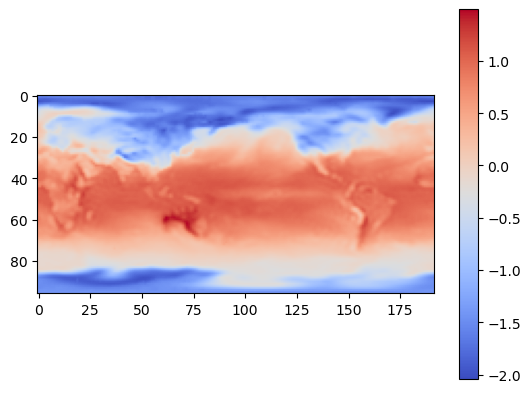

relu_2


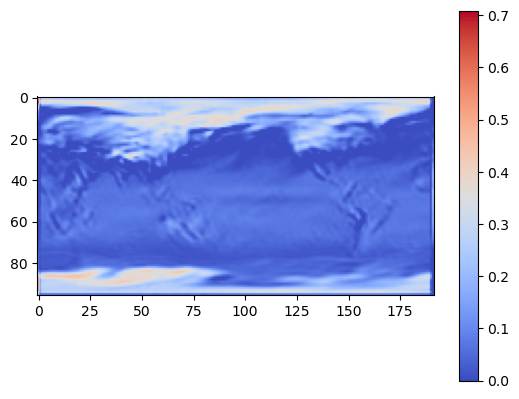

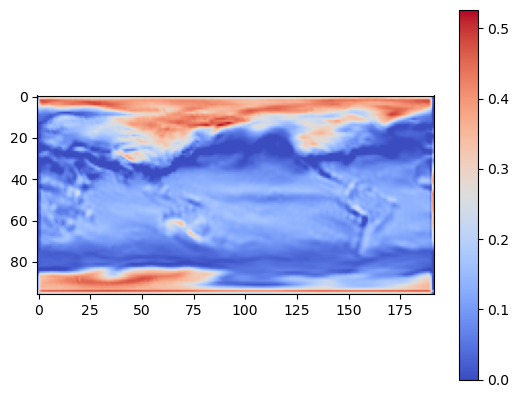

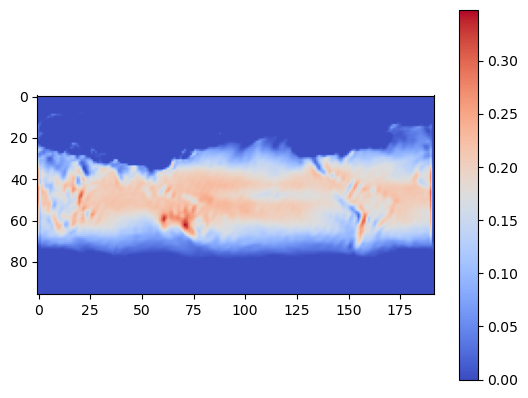

relu_4


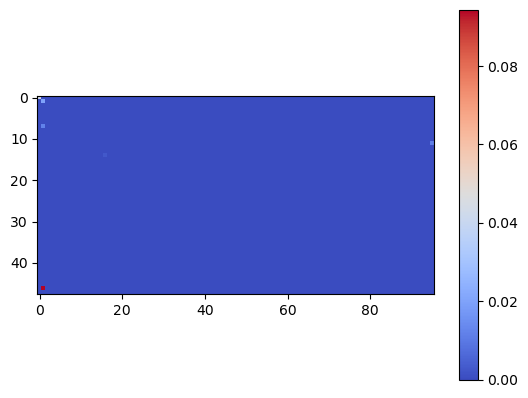

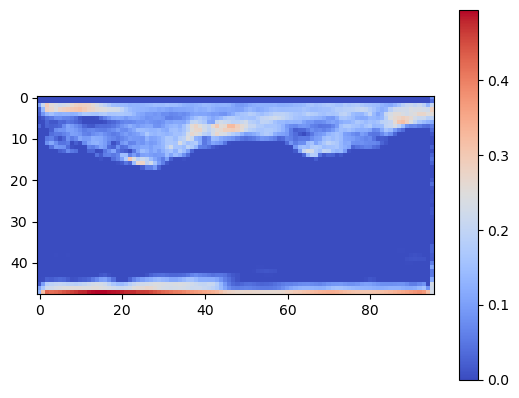

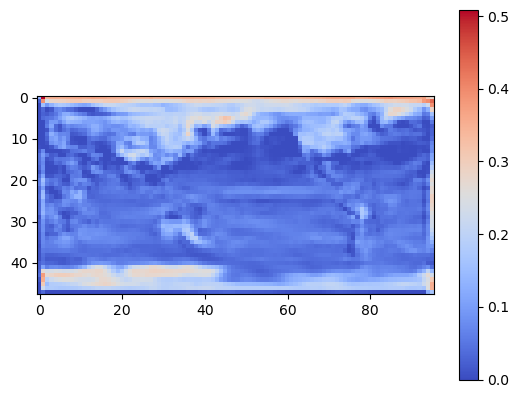

relu_13


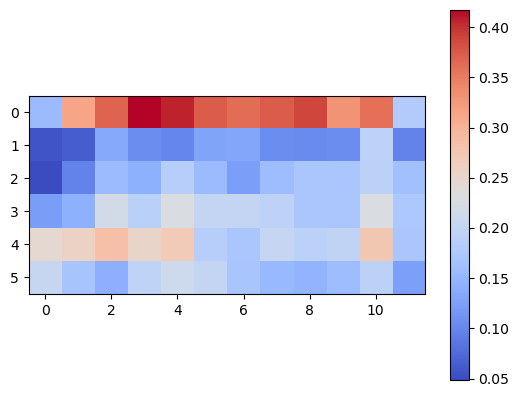

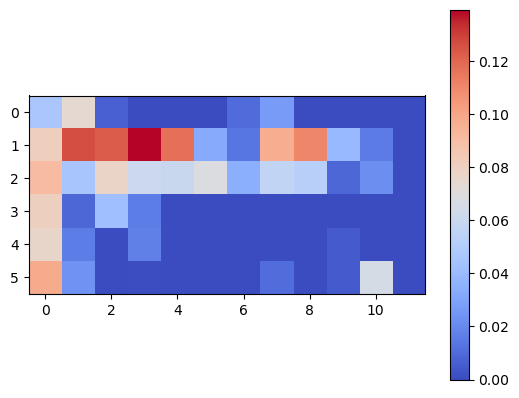

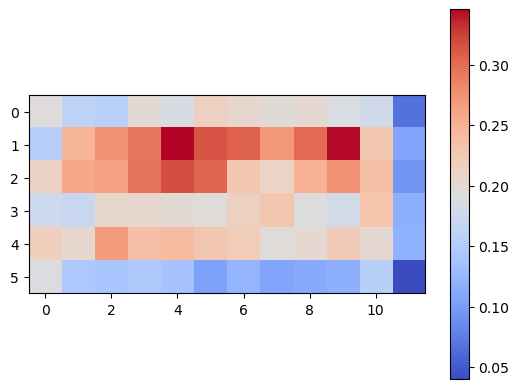

In [77]:
plt.imshow(inp, cmap='coolwarm')
plt.colorbar()
plt.show()
print("relu_2")
for i in range(3):
    plt.imshow(relu_2_output.detach().squeeze().numpy()[i, ...], cmap='coolwarm')
    plt.colorbar()
    plt.show()
print("relu_4")
for i in range(3):
    plt.imshow(relu_4_output.detach().squeeze().numpy()[i, ...], cmap='coolwarm')
    plt.colorbar()
    plt.show()
print("relu_13")
for i in range(3):
    plt.imshow(relu_13_output.detach().squeeze().numpy()[i, ...], cmap='coolwarm')
    plt.colorbar()
    plt.show()

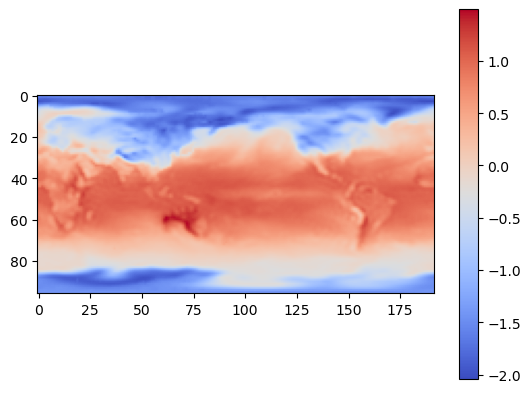

relu_2


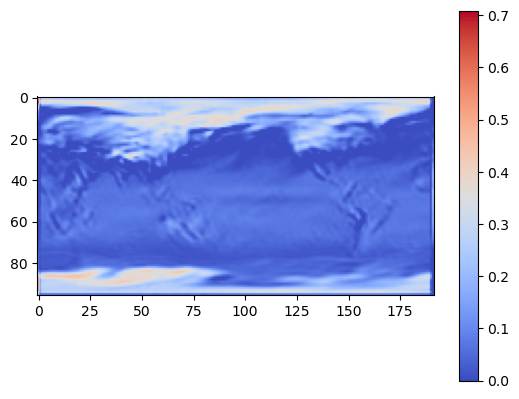

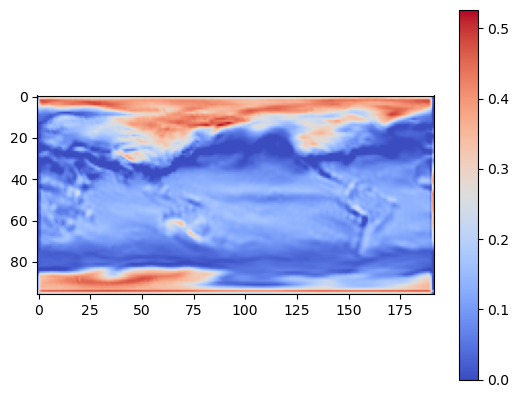

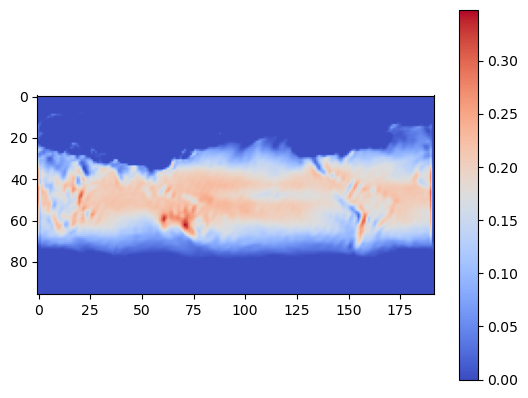

relu_4


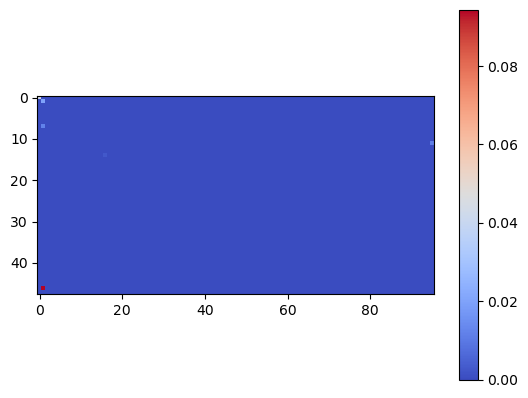

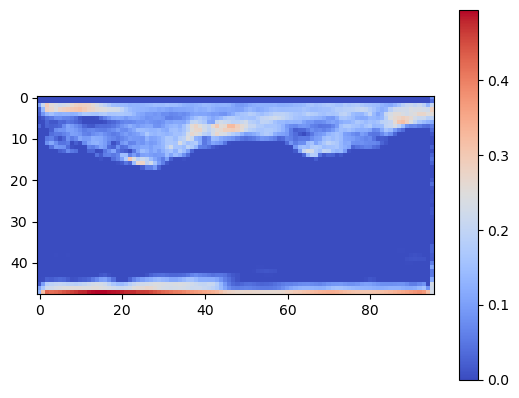

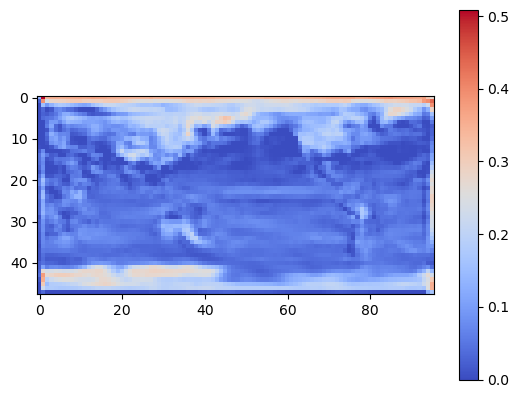

relu_13


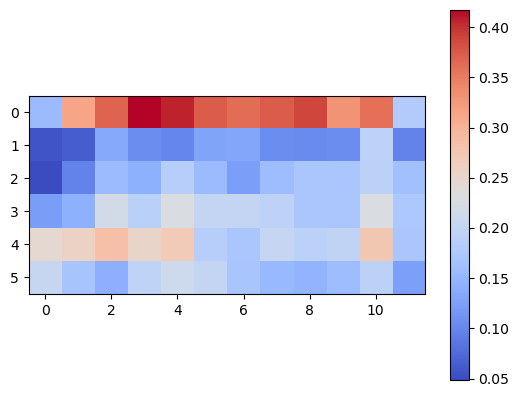

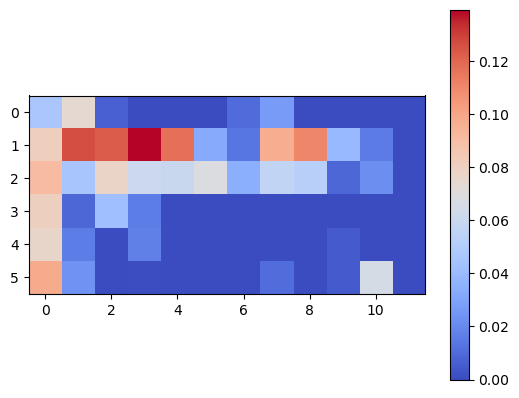

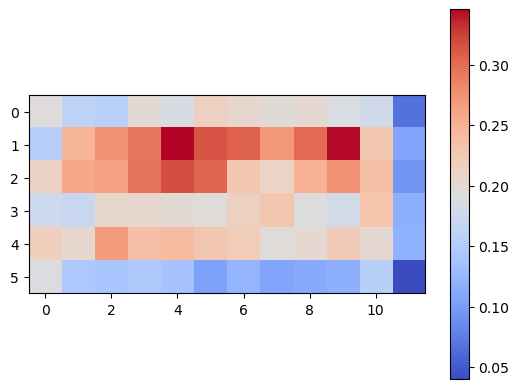

In [74]:
plt.imshow(inp, cmap='coolwarm')
plt.colorbar()
plt.show()
print("relu_2")
for i in range(3):
    plt.imshow(relu_2_output.detach().squeeze().numpy()[i, ...], cmap='coolwarm')
    plt.colorbar()
    plt.show()
print("relu_4")
for i in range(3):
    plt.imshow(relu_4_output.detach().squeeze().numpy()[i, ...], cmap='coolwarm')
    plt.colorbar()
    plt.show()
print("relu_13")
for i in range(3):
    plt.imshow(relu_13_output.detach().squeeze().numpy()[i, ...], cmap='coolwarm')
    plt.colorbar()
    plt.show()

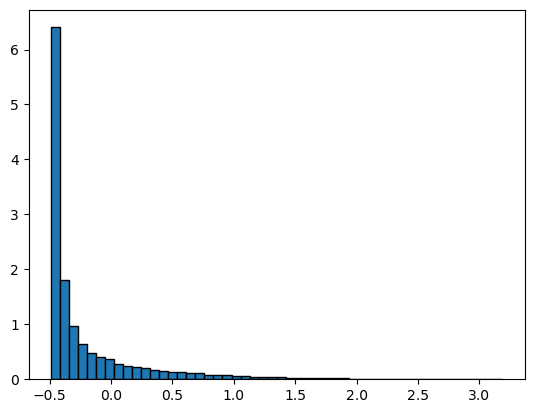

In [67]:
from torchvision.transforms import Lambda
t = Lambda(lambda x: torch.log1p(x))

plt.hist(t(torch.tensor(inp.copy())).flatten(), bins=50, ec='black', density=True)
# plt.hist(inp.flatten(), bins=50, ec='black', density=True)
# plt.xscale('log')
plt.show()

In [66]:
t(torch.tensor(inp.copy())).flatten().max()

tensor(3.1840)

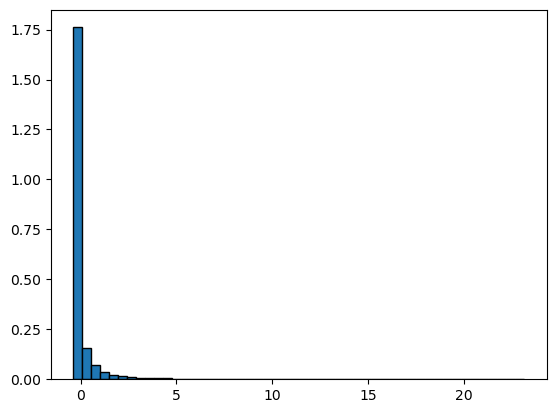

In [48]:
plt.hist(inp.flatten(), bins=50, ec='black', density=True)
# plt.xscale('log')
plt.show()

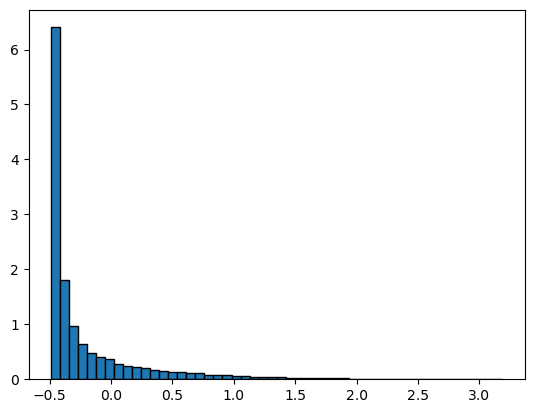

In [51]:
plt.hist(np.log1p(inp.flatten()), bins=50, ec='black', density=True)
# plt.xscale('log')
plt.show()

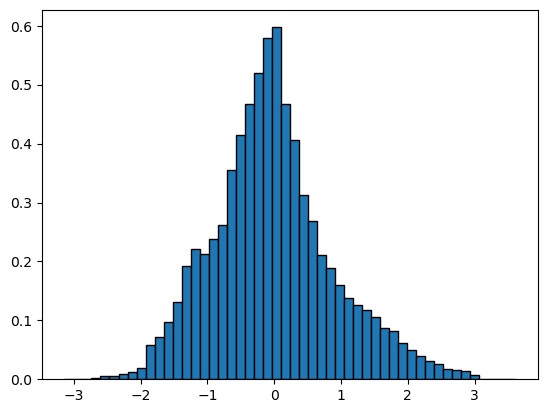

In [46]:
plt.hist(inp.flatten(), bins=50, ec='black', density=True)
# plt.xscale('log')
plt.show()

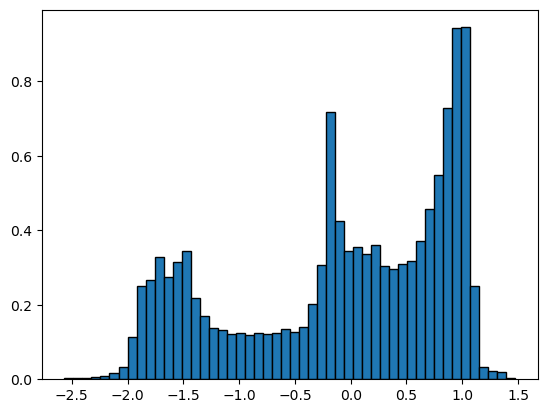

In [40]:
plt.hist(inp.flatten(), bins=50, ec='black', density=True)
# plt.xscale('log')
plt.show()

0it [00:02, ?it/s]


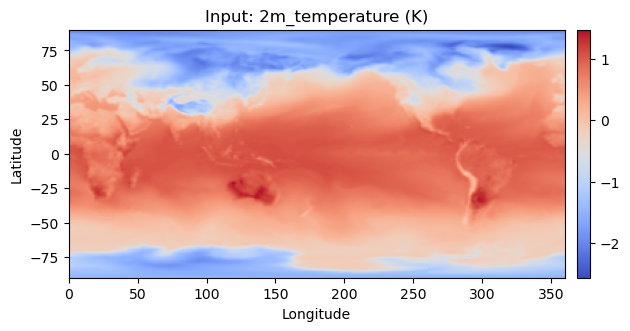

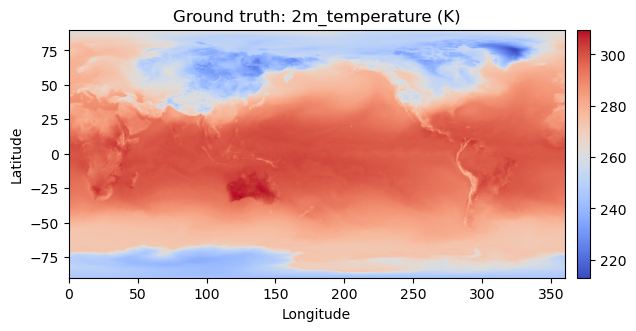

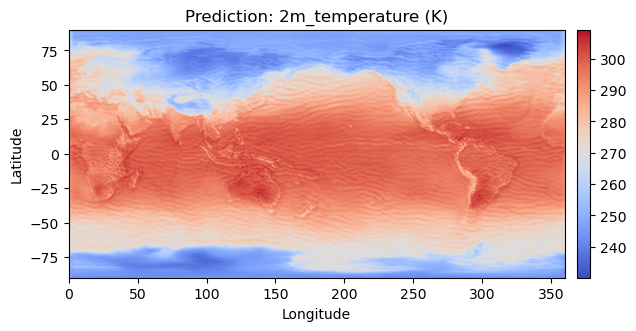

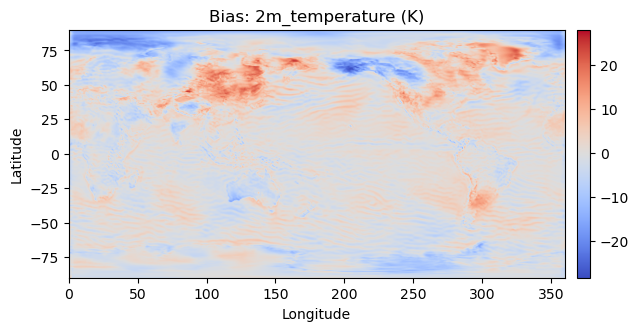

In [84]:
ckpt_perception = "/app/data/experiments/downscaling-CMIP-ERA-D/deepsd_multi_none_777/logs/version_15/checkpoints/epoch_043.ckpt"#"/app/data/experiments/downscaling-CMIP-ERA-D/deepsd_multi_none_777/logs/version_14/checkpoints/epoch_031.ckpt"
ckpt_no_perception = "/app/data/experiments/downscaling-CMIP-ERA-D/deepsd_multi_none_777/logs/version_0/checkpoints/epoch_040.ckpt"
ckpt_fourier = "/app/data/experiments/downscaling-CMIP-ERA-D/deepsd_multi_none_777/logs/version_27/checkpoints/epoch_017.ckpt"
ckpt = ckpt_perception

model = setup_pretrained_module(DeepSDLitModule, module, ckpt, elevation=elevation_list)
denorm = model.test_target_transforms[0]
in_graphic_perception = visualize_at_index(
    model.to(device="cuda:1"),
    dm,
    in_transform=transforms.Normalize(torch.zeros(12), torch.ones(12)),
    out_transform=denorm,
    # variable="10m_u_component_of_wind",
    variable="2m_temperature",
    src="era5",
    index=0,
)

0it [00:02, ?it/s]


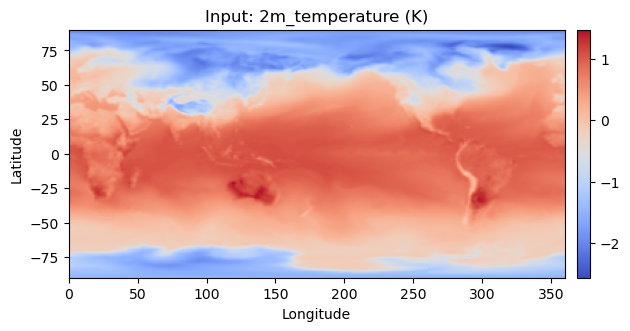

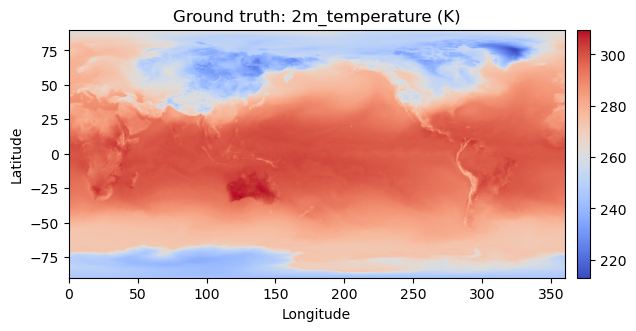

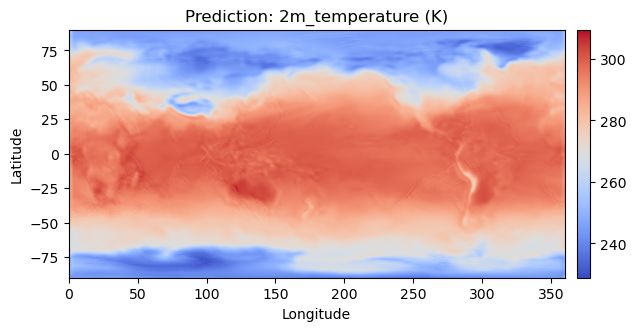

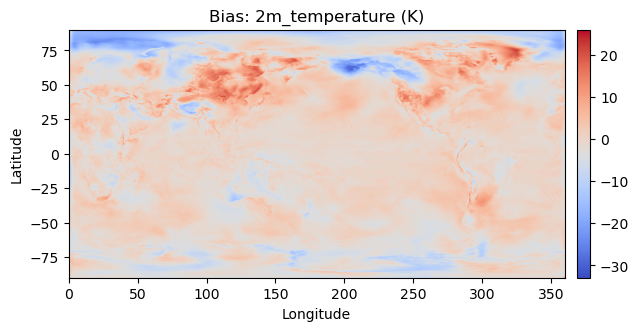

In [86]:
ckpt_perception = "/app/data/experiments/downscaling-CMIP-ERA-D/deepsd_multi_none_777/logs/version_15/checkpoints/epoch_043.ckpt"#"/app/data/experiments/downscaling-CMIP-ERA-D/deepsd_multi_none_777/logs/version_14/checkpoints/epoch_031.ckpt"
ckpt_no_perception = "/app/data/experiments/downscaling-CMIP-ERA-D/deepsd_multi_none_777/logs/version_0/checkpoints/epoch_040.ckpt"
ckpt_fourier = "/app/data/experiments/downscaling-CMIP-ERA-D/deepsd_multi_none_777/logs/version_27/checkpoints/epoch_017.ckpt"
ckpt = ckpt_fourier
def setup_pretrained_module(module_class, module, checkpoint, **kwargs):
    model = module_class.load_from_checkpoint(
            # '/app/data/experiments/downscaling-ERA-ERA/deepsd_multi_none_0/logs/version_0/checkpoints/epoch_024.ckpt',
            checkpoint,
            net=module.net,
            optimizer=module.optimizer,
            lr_scheduler=module.lr_scheduler,
            train_loss=module.train_loss,
            val_loss=module.val_loss,
            test_loss=module.test_loss,
            train_target_transform=module.train_target_transform,
            val_target_transforms=module.val_target_transforms,
            test_target_transforms=module.test_target_transforms,
            **kwargs
        )
    return model
model = setup_pretrained_module(DeepSDLitModule, module, ckpt, elevation=elevation_list)
denorm = model.test_target_transforms[0]
in_graphic_fourier = visualize_at_index(
    model.to(device="cuda:1"),
    dm,
    in_transform=transforms.Normalize(torch.zeros(12), torch.ones(12)),
    out_transform=denorm,
    # variable="10m_u_component_of_wind",
    variable="2m_temperature",
    src="era5",
    index=0,
)

0it [00:03, ?it/s]


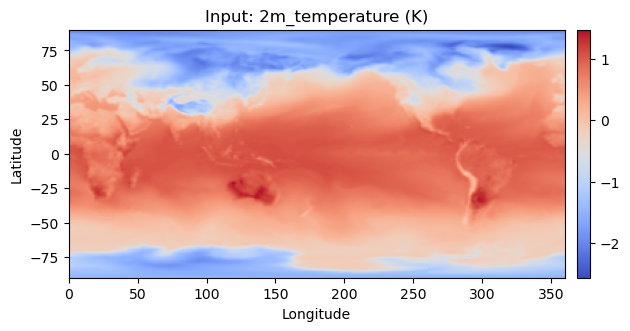

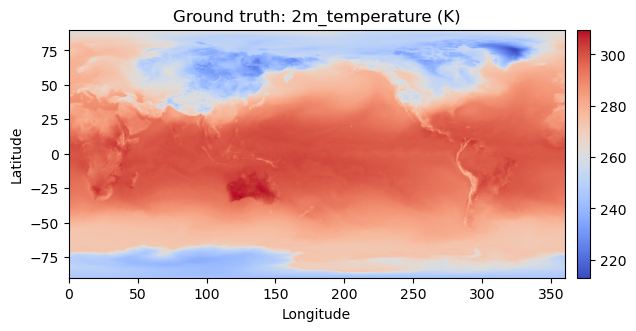

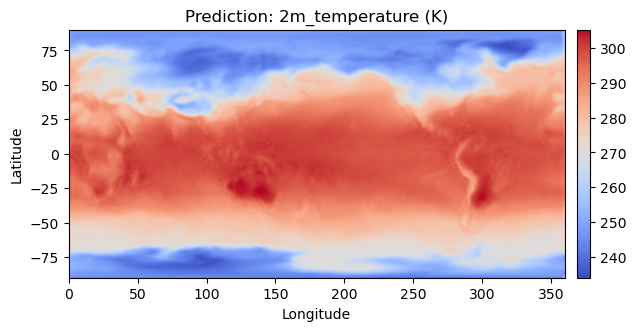

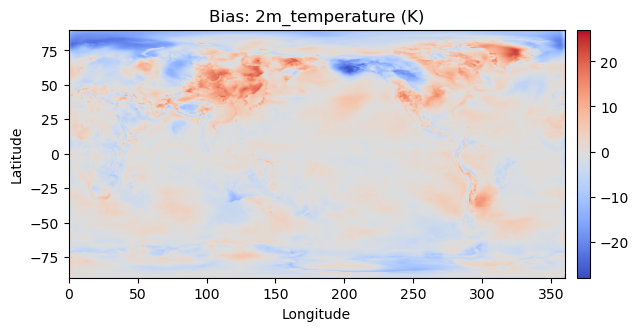

In [72]:
ckpt_perception = "/app/data/experiments/downscaling-CMIP-ERA-D/deepsd_multi_none_777/logs/version_14/checkpoints/epoch_031.ckpt"
ckpt_no_perception = "/app/data/experiments/downscaling-CMIP-ERA-D/deepsd_multi_none_777/logs/version_0/checkpoints/epoch_040.ckpt"
ckpt = ckpt_no_perception
def setup_pretrained_module(module_class, module, checkpoint, **kwargs):
    model = module_class.load_from_checkpoint(
            # '/app/data/experiments/downscaling-ERA-ERA/deepsd_multi_none_0/logs/version_0/checkpoints/epoch_024.ckpt',
            checkpoint,
            net=module.net,
            optimizer=module.optimizer,
            lr_scheduler=module.lr_scheduler,
            train_loss=module.train_loss,
            val_loss=module.val_loss,
            test_loss=module.test_loss,
            train_target_transform=module.train_target_transform,
            val_target_transforms=module.val_target_transforms,
            test_target_transforms=module.test_target_transforms,
            **kwargs
        )
    return model
model = setup_pretrained_module(DeepSDLitModule, module, ckpt, elevation=elevation_list)
denorm = model.test_target_transforms[0]
in_graphic = visualize_at_index(
    model.to(device="cuda:1"),
    dm,
    in_transform=transforms.Normalize(torch.zeros(12), torch.ones(12)),
    out_transform=denorm,
    # variable="10m_u_component_of_wind",
    variable="2m_temperature",
    src="era5",
    index=0,
)

In [87]:
pred, gt, inp = in_graphic
# inp = inp * np.sqrt(273) + 273
pred_p, _, _ = in_graphic_perception
pred_f, _, _ = in_graphic_fourier

In [5]:

def plot_psd(imgs, label_prefixes = [''], linestyles=[None]):
    # curr_dir = os.getcwd()
    # img = cv2.imread(curr_dir+'/temp.png',0)
    assert (len(imgs) == len(label_prefixes)) and (len(imgs) <= len(linestyles)), "number of images labels and linestyles must match"
    # Fourier Transform along the first axis
    fig, (ax1, ax2) = plt.subplots(1, 2)
    for i in range(len(imgs)):
        img = imgs[i]
        label_prefix = label_prefixes[i]
        linestyle = linestyles[i]
        # Round up the size along this axis to an even number
        n = int( math.ceil(img.shape[0] / 2.) * 2 )

        # We use rfft since we are processing real values
        a = np.fft.rfft(img,n, axis=0)

        # Sum power along the second axis
        a = a.real*a.real + a.imag*a.imag
        a = a.sum(axis=1)/a.shape[1]

        # Generate a list of frequencies
        f = np.fft.rfftfreq(n)

        # Graph it
        ax1.plot(f[1:],a[1:], label = label_prefix + " " + 'PSD y vs f_x', linestyle = linestyle)
        ax1.set_ylabel('amplitude')
        ax1.set_ylabel('frequency')
        ax1.set_yscale('log')
        ax1.legend()
        # plt.ylabel( 'amplitude' )
        # plt.xlabel( 'frequency' )
        # plt.yscale( 'log' )
        # Fourier Transform along the second axis

        # Same steps as above
        n = int( math.ceil(img.shape[1] / 2.) * 2 )

        a = np.fft.rfft(img,n,axis=1)

        a = a.real*a.real + a.imag*a.imag
        a = a.sum(axis=0)/a.shape[0]

        f = np.fft.rfftfreq(n)

        ax2.plot(f[1:],a[1:],  label = label_prefix + " " + 'PSD x vs f_y', linestyle = linestyle)

        ax2.set_ylabel('amplitude')
        ax2.set_ylabel('frequency')
        ax2.set_yscale('log')

        ax2.legend()

    # plt.savefig( 'test_rfft.png' )
    # plt.show()

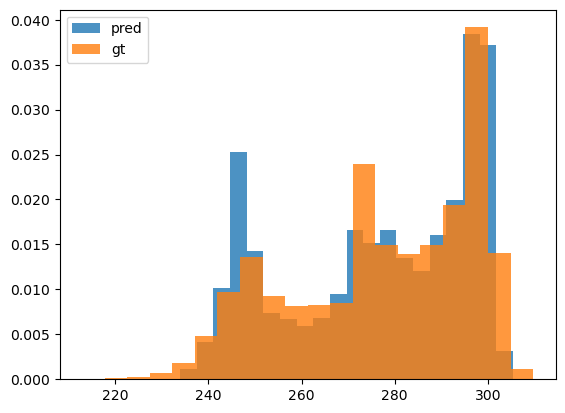

In [92]:

# plt.hist(pred_p.flatten(), bins=20, label='pred_p', alpha=0.8, density=True)
plt.hist(pred.flatten(), bins=20, label='pred', alpha=0.8, density=True)
# plt.hist(pred_f.flatten(), bins=20, label='fourier', alpha=0.8, density=True)
plt.hist(gt.flatten(), bins=20, label='gt', alpha=0.8, density=True)
# plt.hist(inp.flatten(), bins=20, label='inp', alpha=0.8, density=True)
plt.legend()
plt.show()

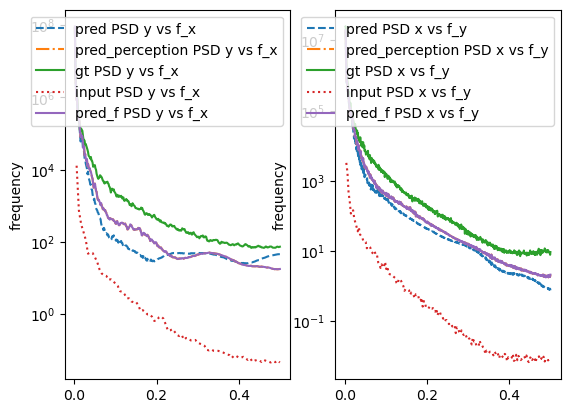

In [93]:
# plot_psd(pred, label_prefix='pred', linestyle = 'dashed')
# plot_psd(pred_p, label_prefix='pred perception', linestyle = '-.')
# plot_psd(gt, label_prefix='gt', linestyle = 'solid')
plot_psd([pred, pred_p, gt, inp, pred_f], label_prefixes=['pred', 'pred_perception', 'gt', 'input', 'pred_f'], linestyles=['dashed', '-.', 'solid', ':', '-'])

In [94]:
def plot_2d_psd(img):
    plt.figure(figsize=(15, 7.5))
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    mag = 20 * np.log(np.abs(fshift))
    plt.subplot(121), plt.imshow(img,cmap='gray')
    plt.subplot(122), plt.imshow(mag,cmap='gray')
    plt.show()
    return mag

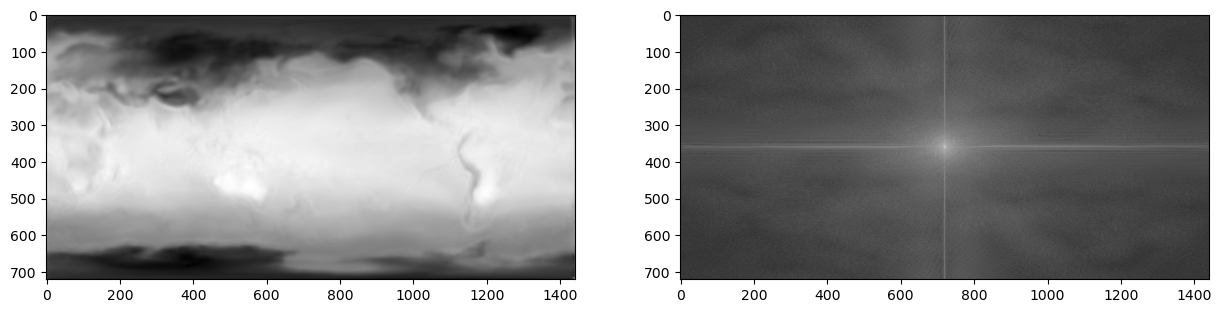

In [95]:
pred_mag = plot_2d_psd(pred)

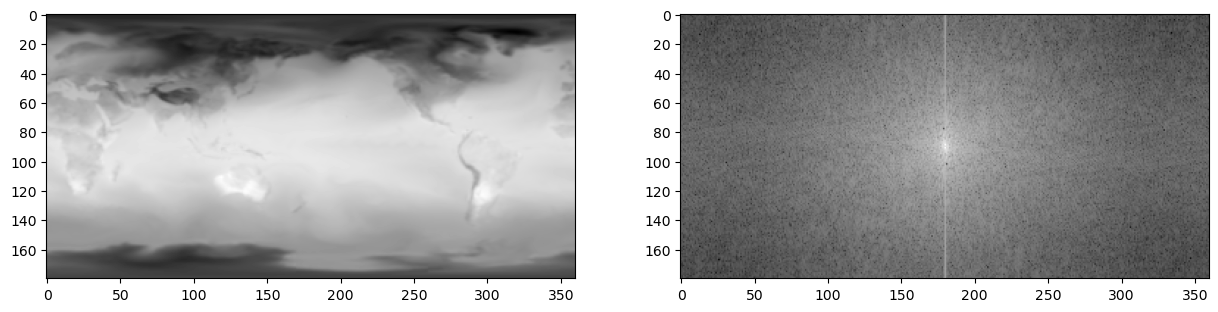

In [96]:
inp_mag = plot_2d_psd(inp)

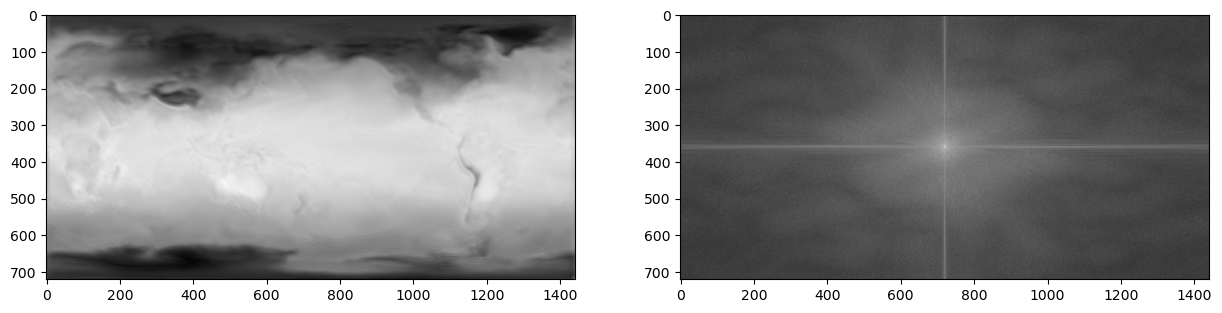

In [97]:
pred_p_mag = plot_2d_psd(pred_p)

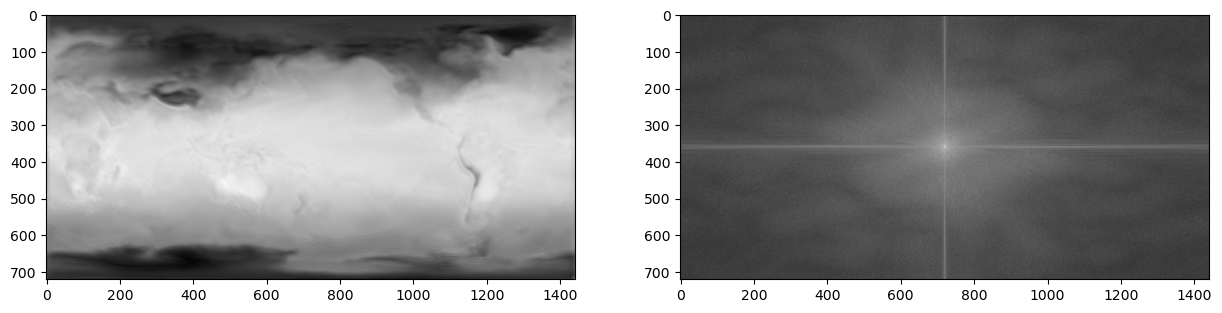

In [99]:
pred_p_mag = plot_2d_psd(pred_f)

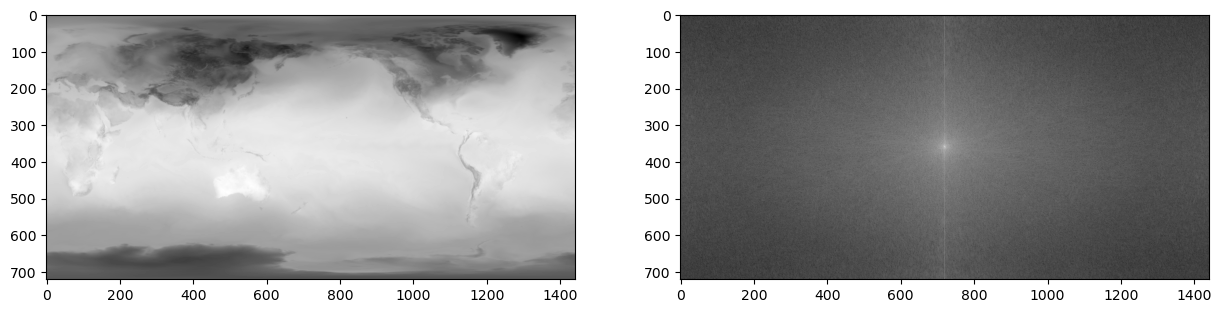

In [98]:
gt_mag = plot_2d_psd(gt)

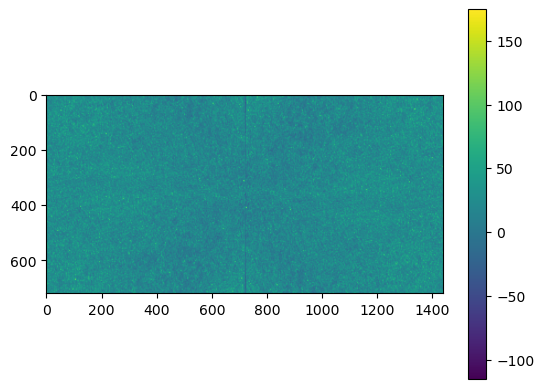

In [15]:
plt.imshow(gt_mag - torch.nn.functional.interpolate(torch.tensor(inp_mag)[None, None, ...], gt_mag.shape).numpy().squeeze())
plt.colorbar()

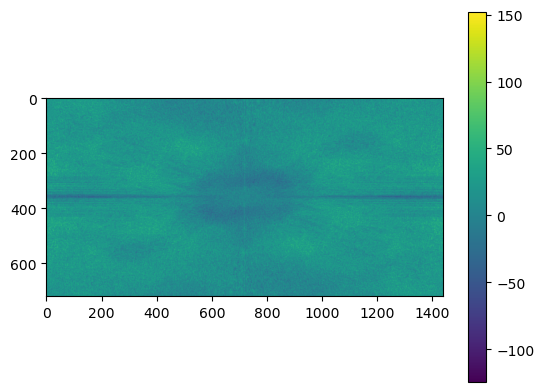

In [16]:
plt.figure()
plt.imshow(gt_mag - pred_p_mag)
plt.colorbar()

In [16]:
import math
class Solution(object):
    def mySqrt(self, x):
        """
        :type x: int
        :rtype: int
        """
        if x ==0:
            return 0
        elif x == 1:
            return 1
        else:
            found = False
            left = 0
            right = x
            half = x // 2
            # print(half)
            while not found:
                # print(left, half, right)
                if half ** 2 == x:
                    return half
                elif half ** 2 > x:
                    right = half
                    left = left
                    half = (left + right) // 2
                elif half ** 2 < x:
                    left = half
                    right = right
                    half = (left + right) // 2
                if right - left == 1:#(left ** 2 >= x) and (right ** 2 <= x):
                    return left
                    

In [19]:
s = Solution()
x = 8
tst = []
for x in range(100):
    # print('my sol', s.mySqrt(x))
    # print('ground', math.floor(math.sqrt(x)))
    # print(s.mySqrt(x) == math.floor(math.sqrt(x)))
    tst.append(s.mySqrt(x) == math.floor(math.sqrt(x)))


In [21]:
res = True
for k in tst:
    res  = res and k